In [1]:
!pip install geopandas contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 73.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, LineString
import torch.nn.functional as F
from geopy.distance import geodesic

In [3]:
# Helper function to convert GPS coordinates to meters
def gps_to_meters(lat_diff, lon_diff, ref_lat):
    lat_meters = lat_diff * 111000  # 1 degree latitude ≈ 111 km
    lon_meters = lon_diff * (111000 * np.cos(np.radians(ref_lat)))  # 1 degree longitude ≈ 111 km * cos(latitude)
    return lat_meters, lon_meters

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load and preprocess data
data = pd.read_csv('/content/drive/MyDrive/Kasungu Telem Pts_June24.csv', parse_dates=['Time.Stamp'])
data = data[["Index", "Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data = data.sort_values(by=['Tag', 'Time.Stamp'])
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data['Latitude'].diff().fillna(0)
data['Lon_diff'] = data['Longitude'].diff().fillna(0)

In [6]:

# Convert GPS differences to meters
data['Lat_meters'], data['Lon_meters'] = gps_to_meters(data['Lat_diff'], data['Lon_diff'], data['Latitude'].mean())

numeric_columns = ['Latitude', 'Longitude']

In [7]:
def create_sequences(data, sequence_length=15, prediction_length=3):
    X, y, tags = [], [], []
    for i in range(sequence_length, len(data) + 1):
        X.append(data.iloc[i-sequence_length:i-prediction_length][['Latitude', 'Longitude']].values.flatten())
        y.append(data.iloc[i-prediction_length:i][['Latitude', 'Longitude']].values.flatten())
        tags.append(data.iloc[i-sequence_length]['Tag'])  # Store the Tag
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(tags)

elephants = data['Tag'].unique()
X_list, y_list, tags_list = [], [], []

for elephant in elephants:
    elephant_data = data[data['Tag'] == elephant]
    if len(elephant_data) >= 110:
        X_elephant, y_elephant, tags_elephant = create_sequences(elephant_data)
        if X_elephant.shape[0] > 0:
            X_list.append(X_elephant)
            y_list.append(y_elephant)
            tags_list.append(tags_elephant)

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
tags = np.concatenate(tags_list, axis=0)

def train_test_split_by_elephant(X, y, tags, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_size = int(len(indices) * test_size)
    train_indices, test_indices = indices[:-test_size], indices[-test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices], tags[train_indices], tags[test_indices]

X_train, X_test, y_train, y_test, tags_train, tags_test = train_test_split_by_elephant(X, y, tags)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [9]:
import torch
import torch.nn as nn

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(LinearRegressionModel, self).__init__()
        layers = []
        current_dim = input_dim

        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())  # Activation function
            current_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(current_dim, output_dim))

        # Combine layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

input_dim = 24  # sequence length
hidden_dims = [128, 256, 128]  #  hidden layer sizes
output_dim = 6  #  prediction length
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearRegressionModel(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Epoch 1: Train Loss: 0.4002, Validation Loss: 0.0241, Train RMSE: 0.6326, Validation RMSE: 0.1552
Epoch 2: Train Loss: 0.0075, Validation Loss: 0.0019, Train RMSE: 0.0863, Validation RMSE: 0.0436
Epoch 3: Train Loss: 0.0053, Validation Loss: 0.0209, Train RMSE: 0.0731, Validation RMSE: 0.1444
Epoch 4: Train Loss: 0.0042, Validation Loss: 0.0035, Train RMSE: 0.0647, Validation RMSE: 0.0594
Epoch 5: Train Loss: 0.0036, Validation Loss: 0.0079, Train RMSE: 0.0603, Validation RMSE: 0.0890
Epoch 6: Train Loss: 0.0031, Validation Loss: 0.0045, Train RMSE: 0.0560, Validation RMSE: 0.0669
Epoch 7: Train Loss: 0.0028, Validation Loss: 0.0022, Train RMSE: 0.0532, Validation RMSE: 0.0470
Epoch 8: Train Loss: 0.0026, Validation Loss: 0.0023, Train RMSE: 0.0510, Validation RMSE: 0.0477
Epoch 9: Train Loss: 0.0024, Validation Loss: 0.0175, Train RMSE: 0.0491, Validation RMSE: 0.1322
Epoch 10: Train Loss: 0.0023, Validation Loss: 0.0043, Train RMSE: 0.0478, Validation RMSE: 0.0656
Epoch 11: Train Los

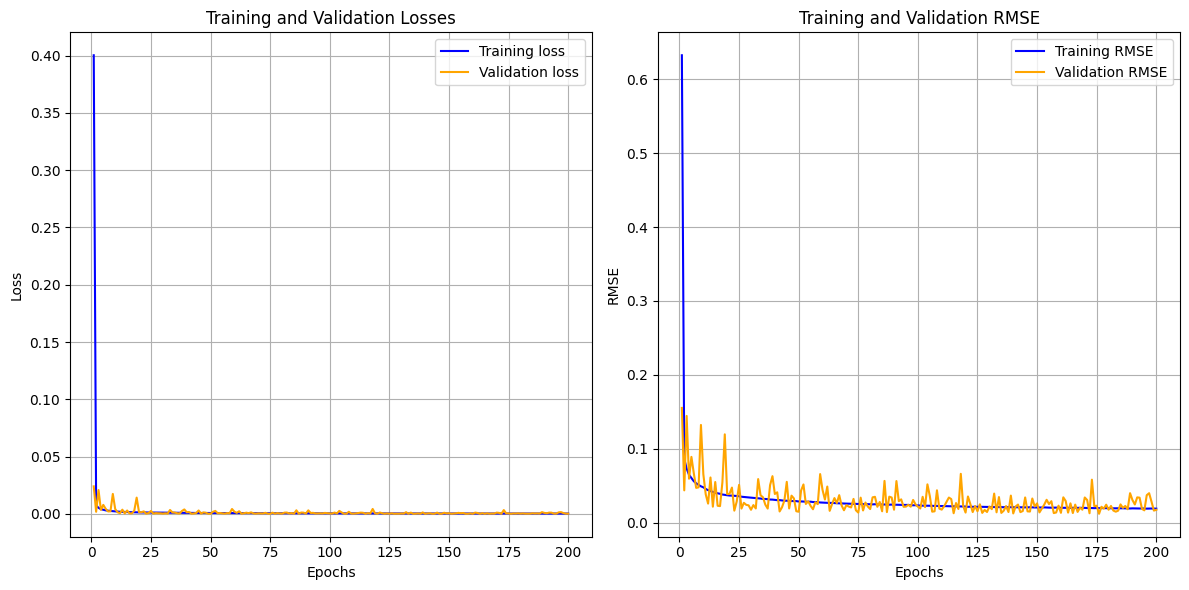

In [10]:
# Training, Validation, and Plotting functions
def train_validate_and_plot(model, train_loader, val_loader, num_epochs, device):
    model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_rmses = []
    val_rmses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization (Gradient Descent)
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        train_rmse = (avg_train_loss ** 0.5)
        val_rmse = (avg_val_loss ** 0.5)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')
        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = avg_val_loss

    # Plotting the results
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    # Plotting losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation loss', color='orange')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plotting RMSE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_rmses, label='Training RMSE', color='blue')
    plt.plot(epochs, val_rmses, label='Validation RMSE', color='orange')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Train and validate the model
train_validate_and_plot(model, train_loader, val_loader, num_epochs=200, device=device)

In [11]:
torch.save(model.state_dict(), 'best_model.pth')

In [17]:
# Evaluation and Plotting
def latlon_to_meters(latlon):
    origin = latlon[0]
    x_distances = [geodesic((origin[0], origin[1]), (origin[0], lon)).meters for lon in latlon[:, 1]]
    y_distances = [geodesic((origin[0], origin[1]), (lat, origin[1])).meters for lat in latlon[:, 0]]
    distances = np.column_stack((x_distances, y_distances))
    return distances

def evaluate_model(model, test_loader, tags_test, device, num_examples=4):
    model.load_state_dict(torch.load('best_model.pth'))  # Load the model
    model.to(device)
    model.eval()

    all_past_data = []
    all_predictions = []
    all_actuals = []
    rmses = []
    tags_list = []

    with torch.no_grad():
        for (X_batch, y_batch), tag in zip(test_loader, tags_test):
            # Ensure data is on the correct device and in float32
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            predictions = model(X_batch)
            predictions = predictions.view(-1, 3, 2).cpu().numpy()
            actuals = y_batch.view(-1, 3, 2).cpu().numpy()
            past_data = X_batch[:, :-6].cpu().numpy().reshape(-1, 12, 2)


            min_batch_size = min(past_data.shape[0], predictions.shape[0])

            for i in range(min_batch_size):

                last_past_point = np.expand_dims(past_data[i][-1], axis=0)

                combined_actuals = np.concatenate([last_past_point, actuals[i]], axis=0)
                combined_predictions = np.concatenate([last_past_point, predictions[i]], axis=0)

                all_past_data.append(past_data[i])
                all_predictions.append(combined_predictions)
                all_actuals.append(combined_actuals)
                tags_list.append(tag)

                batch_rmse = np.sqrt(mean_squared_error(predictions[i], actuals[i]))
                rmses.append(batch_rmse)

    average_rmse = np.mean(rmses)

    # Find the 4 best and 4 worst predictions
    sorted_indices = np.argsort(rmses)
    best_indices = sorted_indices[:num_examples]
    worst_indices = sorted_indices[-num_examples:]

    return np.array(all_past_data), np.array(all_actuals), np.array(all_predictions), rmses, average_rmse, best_indices, worst_indices, tags_list





Average RMSE: 0.015524085
Average RMSE in meters: 1578.145810638294
Mean FDE: 2367.8099901290534
Mean ADE: 1713.236781070217


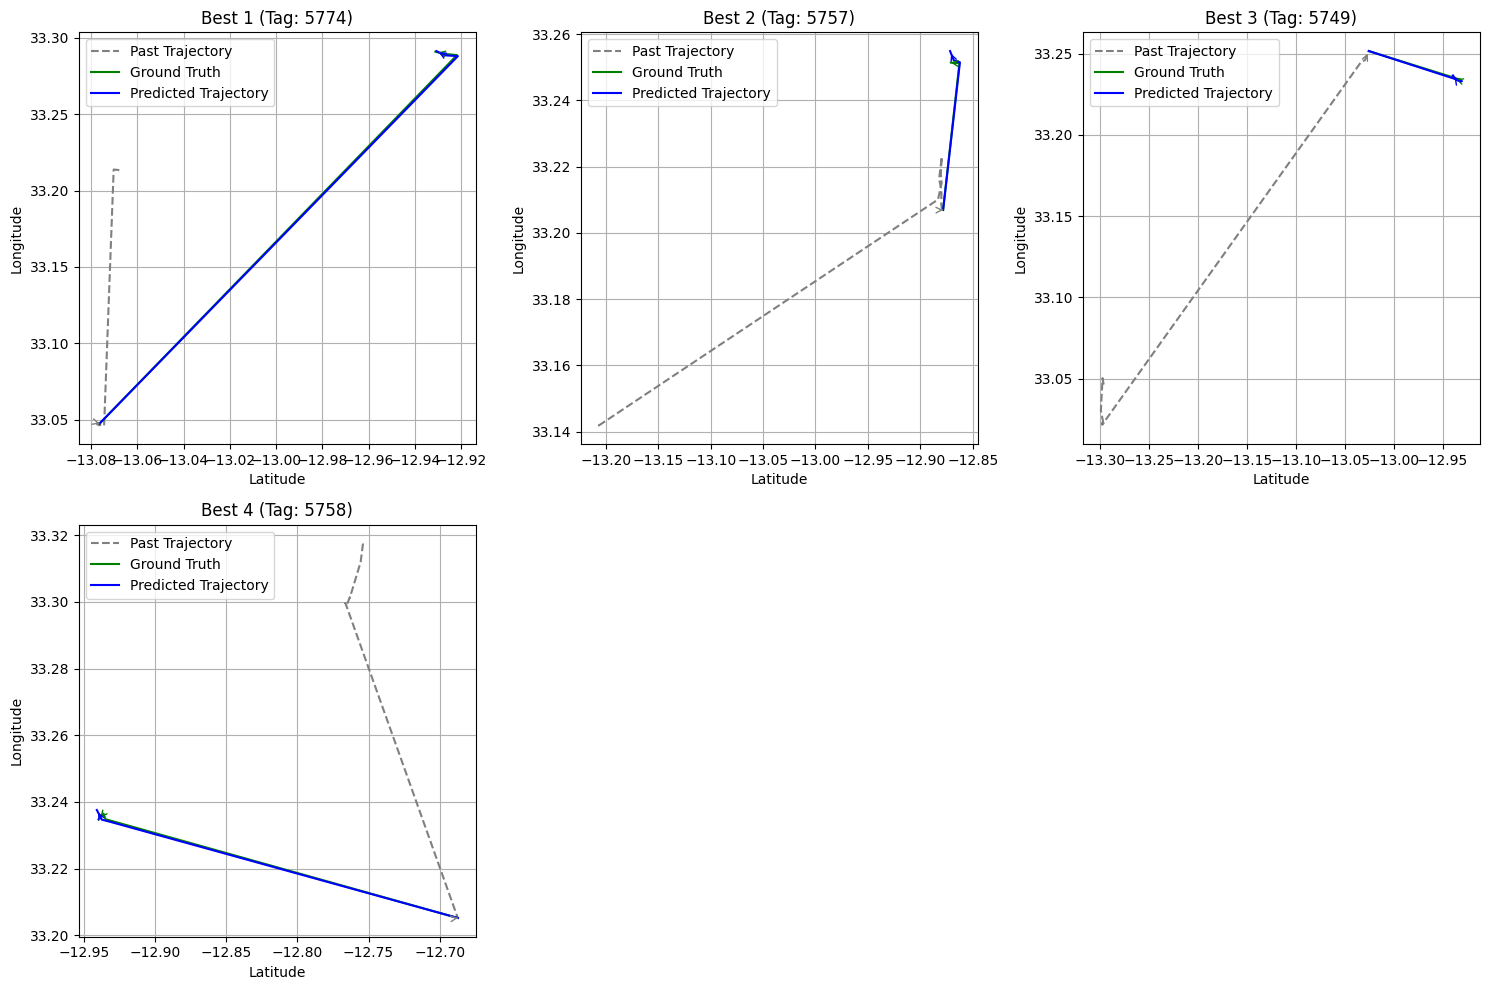

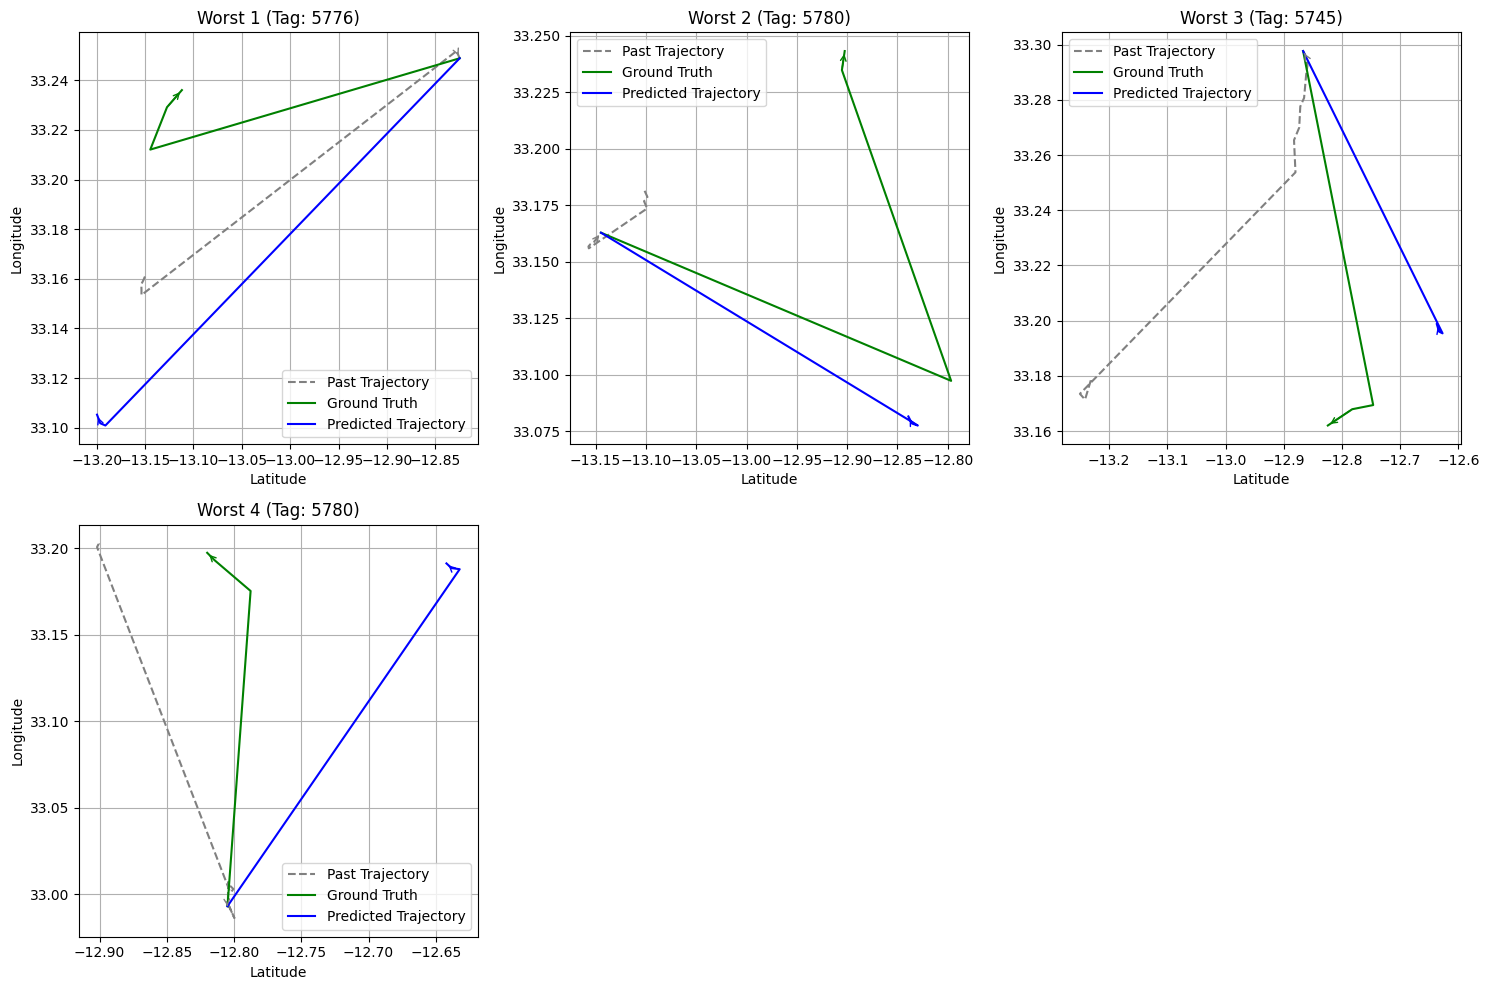

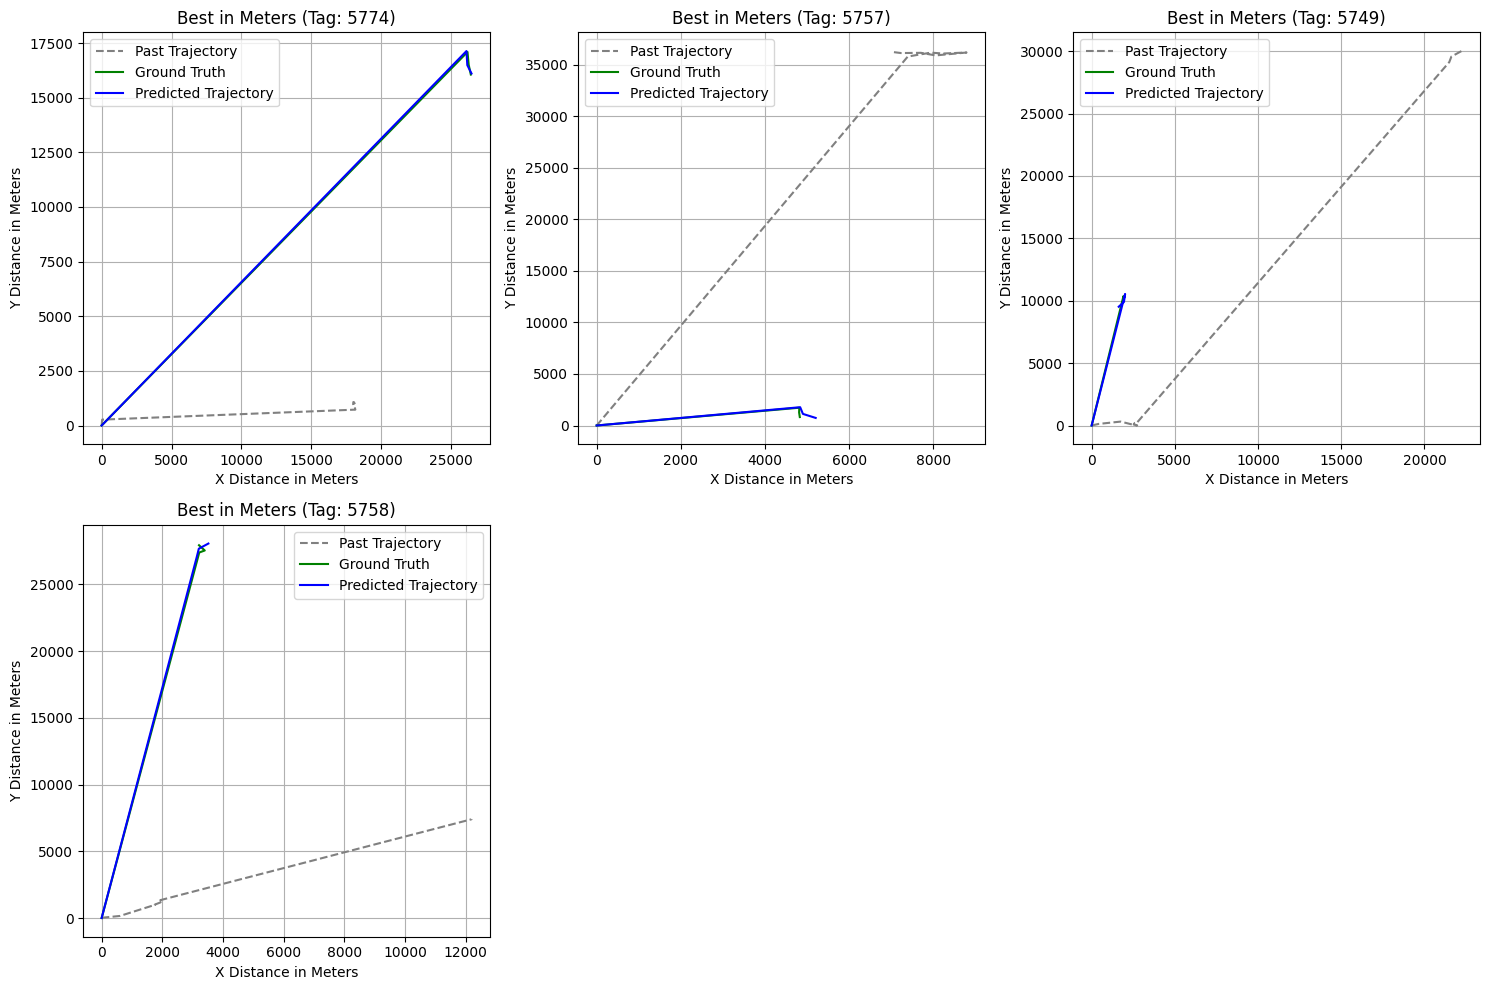

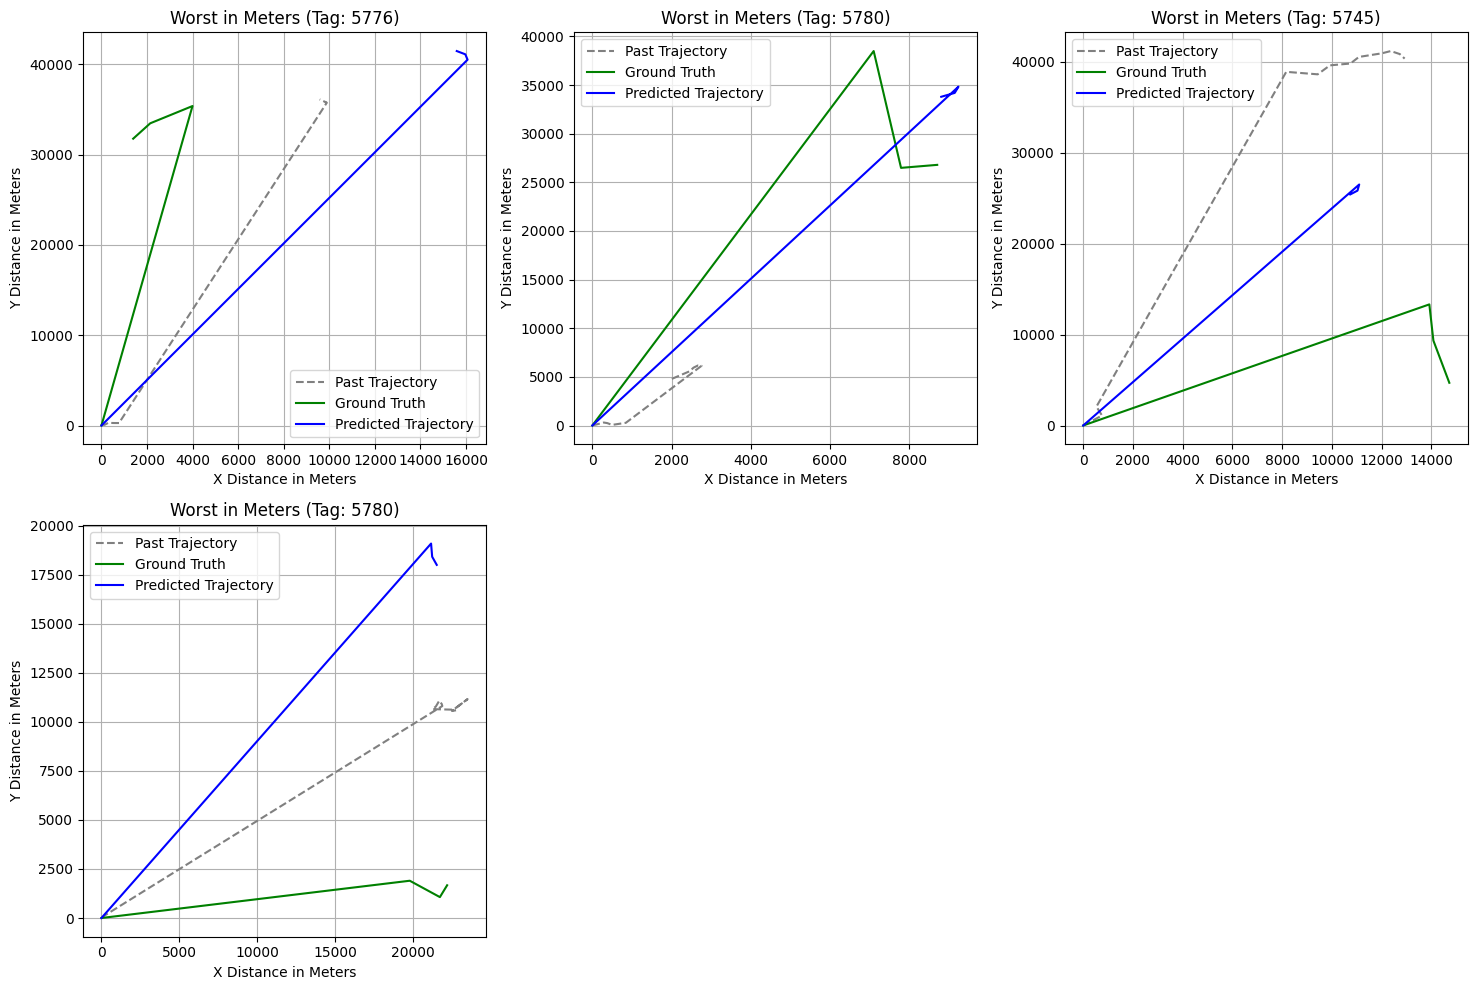

In [19]:
def calculate_additional_metrics(predictions, actuals):
    fdes = []
    ades = []
    angle_errors = []

    all_pred_meters = []
    all_act_meters = []

    for pred, act in zip(predictions, actuals):
        pred_meters = latlon_to_meters(pred)
        act_meters = latlon_to_meters(act)

        all_pred_meters.append(pred_meters)
        all_act_meters.append(act_meters)

        fde = np.linalg.norm(pred_meters[-1] - act_meters[-1])  # Final Displacement Error
        ade = np.mean(np.linalg.norm(pred_meters - act_meters, axis=1))  # Average Displacement Error

        pred_vectors = pred_meters[1:] - pred_meters[:-1]
        act_vectors = act_meters[1:] - act_meters[:-1]
        dot_products = np.einsum('ij,ij->i', pred_vectors, act_vectors)
        norms = np.linalg.norm(pred_vectors, axis=1) * np.linalg.norm(act_vectors, axis=1)

        valid_indices = norms > 0
        cos_angles = np.clip(dot_products[valid_indices] / norms[valid_indices], -1.0, 1.0)
        angles = np.arccos(cos_angles)

        angle_error = np.mean(angles) if angles.size > 0 else 0

        fdes.append(fde)
        ades.append(ade)
        angle_errors.append(angle_error)

    all_pred_meters_flat = np.vstack(all_pred_meters).reshape(-1, 2)
    all_act_meters_flat = np.vstack(all_act_meters).reshape(-1, 2)
    rmse_values = np.sqrt(mean_squared_error(all_pred_meters_flat, all_act_meters_flat))
    average_rmse_meters = np.mean(rmse_values)  # Average RMSE in meters

    mean_fde = np.mean(fdes)  # Mean Final Displacement Error in meters
    mean_ade = np.mean(ades)  # Mean Average Displacement Error in meters
    mean_angle_error = np.mean(angle_errors)  # Mean Angle Error

    return average_rmse_meters, mean_fde, mean_ade, mean_angle_error

def plot_trajectories(past_data, actuals, predictions, indices, tags_list, title='Predictions'):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.plot(past_data[idx][:, 0], past_data[idx][:, 1], 'grey', linestyle ='--', label=f'Past Trajectory ')
        plt.plot(actuals[idx][:, 0], actuals[idx][:, 1], 'g-', label='Ground Truth')
        plt.plot(predictions[idx][:, 0], predictions[idx][:, 1], 'b-', label='Predicted Trajectory')


        plt.annotate('', xy=(actuals[idx][-1, 0], actuals[idx][-1, 1]), xytext=(actuals[idx][-2, 0], actuals[idx][-2, 1]), arrowprops=dict(arrowstyle='->', color='green'))
        plt.annotate('', xy=(predictions[idx][-1, 0], predictions[idx][-1, 1]), xytext=(predictions[idx][-2, 0], predictions[idx][-2, 1]), arrowprops=dict(arrowstyle='->', color='blue'))
        plt.annotate('', xy=(past_data[idx][-1, 0], past_data[idx][-1, 1]), xytext=(past_data[idx][-2, 0], past_data[idx][-2, 1]), arrowprops=dict(arrowstyle='->', color='grey'))

        plt.legend(loc='best')
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.title(f'{title} {i + 1} (Tag: {tags_list[idx]})')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_trajectories_meters(past_data, actuals, predictions, indices, tags_list, title='Predictions in Meters'):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        past_meters = latlon_to_meters(past_data[idx])
        actual_meters = latlon_to_meters(actuals[idx])
        predicted_meters = latlon_to_meters(predictions[idx])

        plt.subplot(2, 3, i + 1)
        plt.plot(past_meters[:, 0], past_meters[:, 1], 'grey', linestyle ='--', label=f'Past Trajectory')
        plt.plot(actual_meters[:, 0], actual_meters[:, 1], 'g-', label='Ground Truth')
        plt.plot(predicted_meters[:, 0], predicted_meters[:, 1], 'b-', label='Predicted Trajectory')

        plt.legend(loc='best')
        plt.xlabel('X Distance in Meters')
        plt.ylabel('Y Distance in Meters')
        plt.title(f'{title} (Tag: {tags_list[idx]})')
        plt.grid(True)
    plt.tight_layout()
    plt.show()



# Evaluate the model and plot results
all_past_data, all_actuals, all_predictions, rmses, average_rmse, best_indices, worst_indices, tags_list = evaluate_model(model, val_loader, tags_test, device=device)

print("Average RMSE:", average_rmse)
# Calculate additional metrics and print them
average_rmse_meters, mean_fde, mean_ade, mean_angle_error = calculate_additional_metrics(all_predictions, all_actuals)
print(f"Average RMSE in meters: {average_rmse_meters}")
print(f"Mean FDE: {mean_fde}")
print(f"Mean ADE: {mean_ade}")

# Plot the 4 best and 4 worst trajectories with original Lat-Long
plot_trajectories(all_past_data, all_actuals, all_predictions, best_indices, tags_list, title='Best')
plot_trajectories(all_past_data, all_actuals, all_predictions, worst_indices, tags_list, title='Worst')




# Plot the 4 best and 4 worst trajectories in meters
plot_trajectories_meters(all_past_data, all_actuals, all_predictions, best_indices, tags_list, title='Best in Meters')
plot_trajectories_meters(all_past_data, all_actuals, all_predictions, worst_indices, tags_list, title='Worst in Meters')

